In [1]:
import numpy as np
import matplotlib
import matplotlib.colors as colors

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

import pickle
from scipy.signal import savgol_filter


In [2]:
BUILD_DATA = False

if BUILD_DATA:
    from yeastevo import Pillars

    # build and read in the sequence information
    fungi_matrix = Pillars()

    # get the set of IDs and read in alligned sequences
    all_valid_IDs = fungi_matrix.all_aligned_scerevisiae_YSNs()

    all_aligned_seqs = {}
    for ysn in all_valid_IDs:        
        all_aligned_seqs[ysn] = fungi_matrix.get_aligned_scerevisiae_sequences(ysn)
        

    with open("output_data/all_aligned_seqs.pkl", "wb") as f:
        pickle.dump(all_aligned_seqs, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    
    with open("output_data/all_aligned_seqs.pkl", "rb") as f:
        all_aligned_seqs = pickle.load(f)
    all_valid_IDs = list(all_aligned_seqs.keys())

    sanity_check_IDR2 = 'MGEYNDLQPSSSSNNNNNNDGELSGTNLRSNSIDYAKHQEISSAGTSSNTTKNVNNNKNDSNDDNNGNNNNDASNLMESVLDKTSSHRYQPKKMPSVNKWSKPDQITHSDVSMVGLDESNDGGNENVHPTLAEVDAQEARETAQLAIDKINSYKRSIDDKNGDGHNNSSRNVVDENLINDMDSEDAHKSKRQHLSDITLEERNEDDKLPHEVAEQLRLLSSHLKEVENLHQNNDDDVDDVMVDVDVESQYNKNTTHHNNHHSQPHHDEEDVAGLIGKADDEEDLSDENIQPELRGQ'

In [3]:
from sparrow import Protein
import protfasta

In [4]:
from shephard.exceptions import ProteomeException
from shephard import interfaces
from shephard.apis import fasta


In [5]:
yeast_proteome = fasta.fasta_to_proteome('../figure_1/data/yeast_sequence_dataset.fasta',use_header_as_unique_ID=True)
interfaces.si_tracks.add_tracks_from_file(yeast_proteome,'../figure_1/data/conservation_scores_SHPRD.tsv', mode='values')
interfaces.si_tracks.add_tracks_from_file(yeast_proteome,'../figure_1/data/pLDDT_scores_SHPRD.tsv', mode='values')
interfaces.si_tracks.add_tracks_from_file(yeast_proteome,'../figure_1/data/disorder_scores_SHPRD.tsv', mode='values')
interfaces.si_domains.add_domains_from_file(yeast_proteome,'../figure_1/data/idrs_shephard.tsv')
interfaces.si_domains.add_domains_from_file(yeast_proteome,'../figure_1/data/pLDDT_domains_SHPRD.tsv')

interfaces.si_protein_attributes.add_protein_attributes_from_file(yeast_proteome,'../figure_1/data/number_of_orthologs_SHPRD.tsv')
interfaces.si_protein_attributes.add_protein_attributes_from_file(yeast_proteome,'../figure_1/data/essential_proteins_SHPRD.tsv')

In [6]:
#
idx = 'YMR136W_Scerevisiae_YMR136W'

In [7]:
# ------------------------------------------------
#
def clean_seq(s):
    """
    Function that takes an aligned sequence (i.e. with '-' characters for gaps) and returns the 
    gap-free sequence.
    
    Parameters
    ------------
    s : str
        Gapped sequence
        
    Returns
    ------------
    str
        Gap-free sequence
    """
    return s.replace('-','')


# ------------------------------------------------
#
def map_sc_to_global(cerevisiae_aligned_sequence):
    """
    Function that takes a sequence that contains '-' (gaps) and returns a dictionary where
    the local (gap-free) numbering for that sequence will return the corresponding global
    alignment. Means that boundaries for IDRs from S. cerevisea can then be translated into
    positions in a global MSA.
    
    Parameters
    ---------------
    s : str
        Gapped sequence
        
    Returns
    ---------------
    dict
        Returns a dictionary where keys are position from an ungapped version of the protein
        and values are corresponding positions in the global MSA gapped sequence.
    
    """
    
    sc2global = {}
    
    local = 0
    for i in range(len(cerevisiae_aligned_sequence)):
        sc2global[local] = i

        if cerevisiae_aligned_sequence[i] != '-':
            local = local + 1
            
    return sc2global

# ------------------------------------------------
#
def compositional_conservation(idr_list, residues, mode='all'):
    """
    Function that computes compositional conservation for a set of IDRs, where conservation
    is calculated based on the sequence of the IDRs and the list of residues passed into residues.
    
    Specifically this function determines the fraction of each IDR set by the combination of residues
    in the residues list, and then computes the mean difference between all IDRs to give an 'average'
    distance between all. The bigger then value, the more divergent.
    
    Parameters
    ------------
    idr_list : list
        List of amino acid sequences
        
    residues : list
        List of amino acid residues whereby those will be used to assess composition
                
    mode : str
        Selector that defines the return mode. Default is all, which means the function returns a 
        tuple with (mean, median), if 'median' passed only median returned, if 'mean' passed only mean
        returned. Must be one of median, mean, or all.
        
        
    Returns
    ------------
        Tuple or float, depending on the mode keyword.
        
    """
    
    comps = []
    for idr in idr_list:
        f = Protein(idr).amino_acid_fractions
        total = 0
        for r in residues:
            total = total + f[r]
        comps.append(total)
    
    local_dif = []
    for i1 in range(len(comps)):
        for i2 in range(i1,len(comps)):
            local_dif.append(abs(comps[i1]-comps[i2]))
            
    if mode == 'median':
        return np.median(local_dif)
    elif mode == 'mean':
        return np.mean(local_dif)
    elif mode == 'all':
        return (np.mean(local_dif), np.median(local_dif))
    else:
        raise Exception('Invalid mode passed.')
        


## Build mapping
This is really dumb, but there are like 50 inconsistent mappings that mean we have to build this manual lookup table...

In [8]:
SANITY_CHECK = True

if SANITY_CHECK:
    print('Running sanity check...')
    sanity_ysn_to_yeast_proteome_idx = {}
    for ysn in all_valid_IDs:
        sanity_ysn_to_yeast_proteome_idx[ysn] = []
        for x in yeast_proteome.proteins:
            local_ysn = x.split('_')[0]
            if local_ysn == ysn:
                sanity_ysn_to_yeast_proteome_idx[ysn].append(x)
                
                
    # now check for any non 1:1 mappings...           
    print('Checking for non 1-1 mappings')
    for x in sanity_ysn_to_yeast_proteome_idx:
        if len(sanity_ysn_to_yeast_proteome_idx[x]) != 1:
            print(x)
            print(sanity_ysn_to_yeast_proteome_idx[x])
            
ysn_to_yeast_proteome_idx = {}
for ysn in all_valid_IDs:
    for x in yeast_proteome.proteins:
        local_ysn = x.split('_')[0]
        if local_ysn == ysn:
            ysn_to_yeast_proteome_idx[ysn] = x
        
    
            
                
    

Running sanity check...
Checking for non 1-1 mappings


In [9]:
compositional_residues = {}
compositional_residues['negative'] = ['E','D']
compositional_residues['positive'] = ['R','K']
compositional_residues['hydrophobic'] = ['L','I','V','M','Y','F','W']
compositional_residues['polar'] = ['G','S','Q','N','H','T']

In [10]:
output_data = {}

colormap = {}
colormap['positive'] = 'Blues'
colormap['negative'] = 'Reds'
colormap['polar'] = 'Greens'
colormap['hydrophobic'] = 'Greys'

color_name = {}
color_name['positive'] = 'blue'
color_name['negative'] = 'red'
color_name['polar'] = 'green'
color_name['hydrophobic'] = 'grey'

bounds1= np.linspace(0, 1, 3)
bounds2 = np.linspace(1, 40, 20)
bounds = np.concatenate((bounds1, bounds2))
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

UPPER_BOUNDS_CONSERVATION_THRESH = 0.1

gridsize=60


# set mode to either IDR or 'structured_domains'

for mode in ['IDR', 'structured_domains']:
    
    IDR_compositional_conservation_mean = {}
    IDR_compositional_conservation_median = {}
    
    for residue_groups in compositional_residues:
        IDR_compositional_conservation_mean[residue_groups] = []
        IDR_compositional_conservation_median[residue_groups] = []
        
    IDR_alignment_conservation_mean = []
    IDR_alignment_conservation_median = []
    
    
    IDR_skip_count = 0
    for ysn in all_valid_IDs:
        
        # define the index as used by the yeast_proteome SHEPHARD object
        alt_proteome_idx = f"{ysn}_Scerevisiae_{ysn}"
        
        proteome_idx = ysn_to_yeast_proteome_idx[ysn]
        
        # get the aligned sequences associated with this S. cerevisiae protein
        #aligned_sequences = fungi_matrix.get_aligned_scerevisiae_sequences(ysn)
        aligned_sequences = all_aligned_seqs[ysn]
            
        # get the S. cerevisiae aligned sequence
        aligned_scer = aligned_sequences[proteome_idx]
            
        # get the mapping of S. cerevisiae position to alignment position
        positional_mapping = map_sc_to_global(aligned_scer)
        
        # extract the protein associated with this YSN
        try:
            protein = yeast_proteome.protein(proteome_idx)
        except ProteomeException:
            print(proteome_idx)
            
        for domain in protein.domains:
            if domain.domain_type == mode:
                
                ## Section below extracts out all the orthologous IDRs
                ## 
                # -1 to account for conversion from real world counting to Python counting
                global_start = positional_mapping[domain.start-1]
                    
                # no -1 because real-world is inclusive
                global_end = positional_mapping[domain.end-1]
                
                    
                local_idrs = []
                for s in aligned_sequences:
                    idr_seq = clean_seq(aligned_sequences[s][global_start:global_end])
                    
                    # each IDR must be 10 residues or longer
                    if len(idr_seq) > 10:
                        local_idrs.append(idr_seq)
                        
                        
                if len(local_idrs) < 10:
                    IDR_skip_count = IDR_skip_count +1
                    continue
    
                    
                # get alignment score as mean conservation
                domain.add_attribute('mean_conservation', np.mean(domain.get_track_values('conservation')))
                domain.add_attribute('median_conservation', np.median(domain.get_track_values('conservation')))
                
                
                IDR_alignment_conservation_mean.append(np.mean(domain.get_track_values('conservation')))
                IDR_alignment_conservation_median.append(np.median(domain.get_track_values('conservation')))
                
                # for each residue group
                for residue_groups in compositional_residues:
                    
                    
                    # returns a tuple with (mean,median) compositional conservation
                    local_comp_cons = compositional_conservation(local_idrs, compositional_residues[residue_groups])
                    
                    IDR_compositional_conservation_mean[residue_groups].append(local_comp_cons[0])
                    IDR_compositional_conservation_median[residue_groups].append(local_comp_cons[1])
                    
                    
                    domain.add_attribute(f'mean_composition_conservation_{residue_groups}', local_comp_cons[0])
                    domain.add_attribute(f'median_composition_conservation_{residue_groups}', local_comp_cons[1])


    # define abf1 IDR2
    IDR2 = yeast_proteome.protein('YKL112W_Scerevisiae_YKL112W').domains[4]
    
    if sanity_check_IDR2 != IDR2.sequence:
        raise Exception('IDR2 not defined correctly...')
    
    if f"{IDR2.start}-{IDR2.end}" != '436-731':
        raise Exception('IDR2 not defined correctly...')
    
    
    for residue_group in compositional_residues:
        
        d = IDR_compositional_conservation_mean[residue_group]
        
        fig, ax = plt.subplots(figsize=(3,3), dpi=200)
        hb = ax.hexbin(d, IDR_alignment_conservation_mean, gridsize=gridsize, cmap=colormap[residue_group], norm=norm)
        
        
        if mode == 'IDR':
            abf1_conservation = IDR2.attribute('mean_conservation')
            abf1_cons_conservation = IDR2.attribute(f'mean_composition_conservation_{residue_group}')   
            plt.plot(abf1_cons_conservation, abf1_conservation,'o',alpha=0.5, color=color_name[residue_group], mew=0)
            plt.plot(abf1_cons_conservation, abf1_conservation,'ok',markerfacecolor='None')
    
    
        plt.ylim([0.2, 0.9])
        plt.xlim([0, 0.2])
        plt.xticks([0,0.05,0.1,0.15],['0','5','10', '15'])
        plt.tight_layout()
        plt.savefig(f"figures/{mode}_mean_{residue_group}.pdf")
        plt.close()
        
        fig, ax = plt.subplots(figsize=(3,3), dpi=200)
        hb = ax.hexbin(d, IDR_alignment_conservation_median, gridsize=gridsize, cmap=colormap[residue_group], norm=norm)
    
        if mode == 'IDR':
            abf1_conservation = IDR2.attribute('median_conservation')
            abf1_cons_conservation = IDR2.attribute(f'median_composition_conservation_{residue_group}')    
            plt.plot(abf1_cons_conservation, abf1_conservation,'o',alpha=0.5, color=color_name[residue_group], mew=0)
            plt.plot(abf1_cons_conservation, abf1_conservation,'ok',markerfacecolor='None')
            
            plt.plot([0,0.2],[IDR2.attribute('median_conservation')+UPPER_BOUNDS_CONSERVATION_THRESH,IDR2.attribute('median_conservation')+UPPER_BOUNDS_CONSERVATION_THRESH],'--k',linewidth=0.5)
    
        
        plt.ylim([0.2, 0.9])
        plt.xlim([0, 0.2])
        plt.xticks([0,0.05,0.1,0.15],['0','5','10', '15'])
        plt.tight_layout()
        plt.savefig(f"figures/{mode}_median_{residue_group}.pdf")
        plt.close()
        
        
                    


In [12]:

# figures in SI use median
averaging_mode='median'

compositional_histogram_data = {}
compositional_histogram_data['positive'] = []
compositional_histogram_data['negative'] = []
compositional_histogram_data['polar'] = []
compositional_histogram_data['hydrophobic'] = []

UPPER_BOUNDS_CONSERVATION_THRESH = 0.1

for protein in yeast_proteome:
    for domain in protein.domains:
        if domain.domain_type == 'IDR':
            if f'{averaging_mode}_conservation' in domain.attributes:
                if domain.attribute(f'{averaging_mode}_conservation') < IDR2.attribute(f'{averaging_mode}_conservation')+UPPER_BOUNDS_CONSERVATION_THRESH:
                    
                    for residue_type in compositional_histogram_data:
                        compositional_histogram_data[residue_type].append(domain.attribute(f'{averaging_mode}_composition_conservation_{residue_type}'))
            
            
for residue_type in compositional_histogram_data:
    compositional_histogram_data[residue_type].sort()
            
            
            
for residue_type in compositional_histogram_data:
    
    percentile = np.argmin(abs(np.array(compositional_histogram_data[residue_type]) - IDR2.attribute(f'{averaging_mode}_composition_conservation_{residue_type}')))/len(compositional_histogram_data[residue_type])
    print(f"{residue_type} => {1-percentile}")


            
            
            
            
            
            

positive => 0.9342010122921186
negative => 0.6329235960472404
polar => 0.4784285369968667
hydrophobic => 0.925765244637262


0.012285447053767787
0.029776328052190132
0.06596031593141982
0.016696217494089838


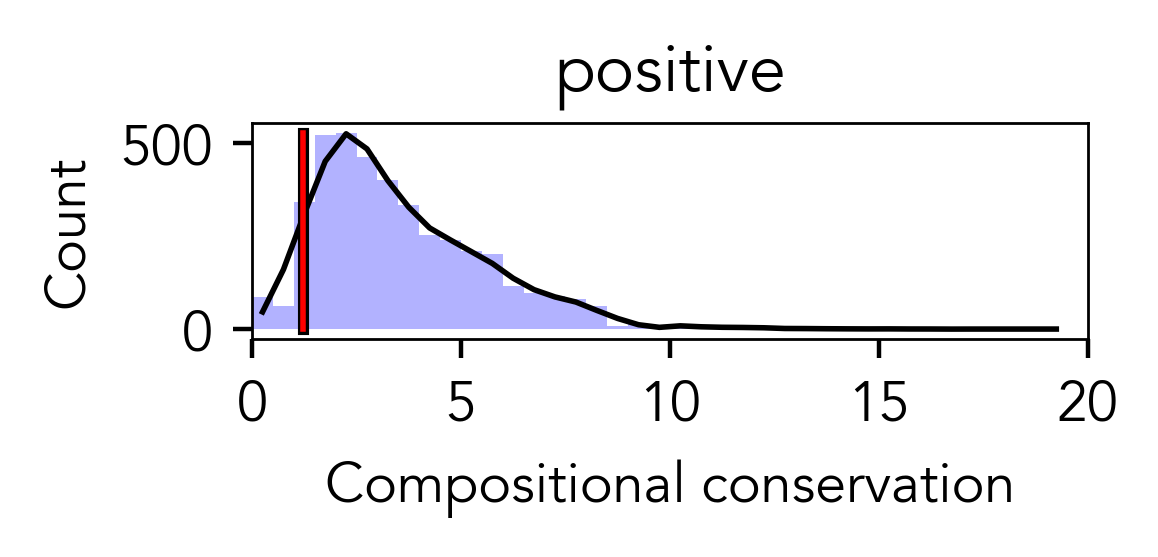

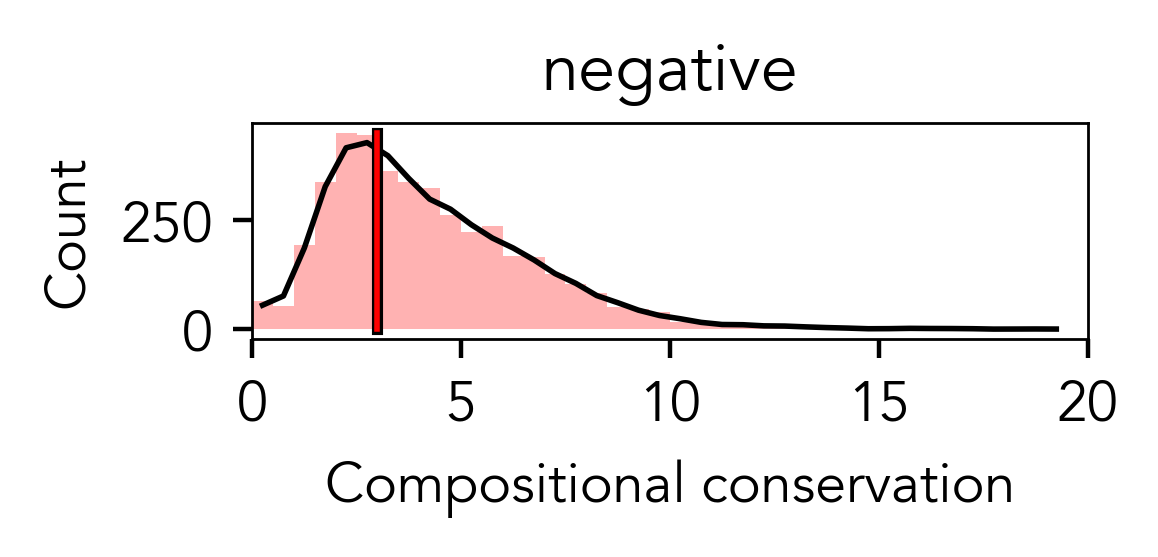

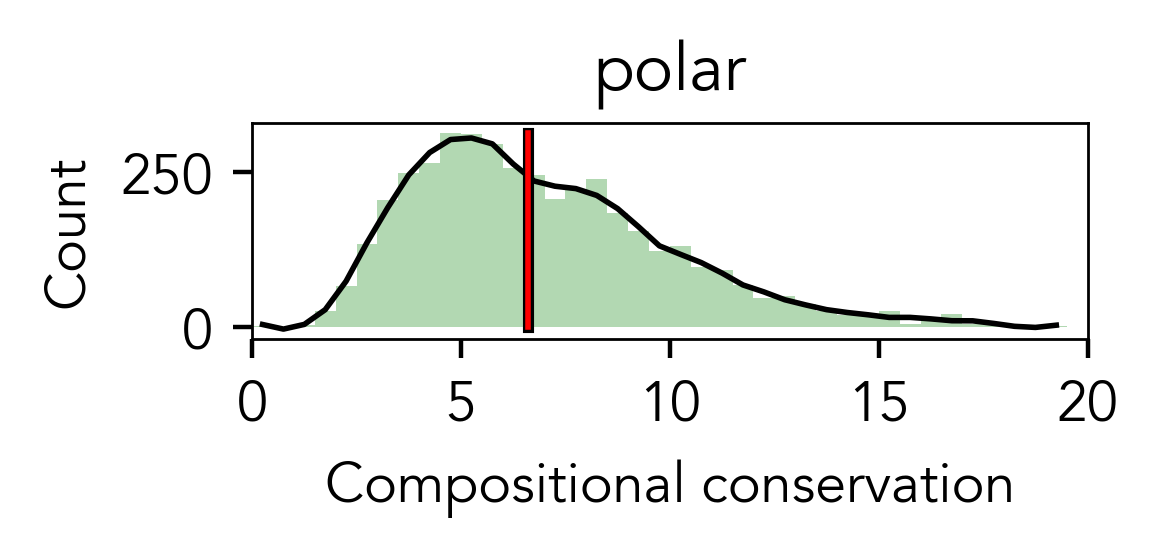

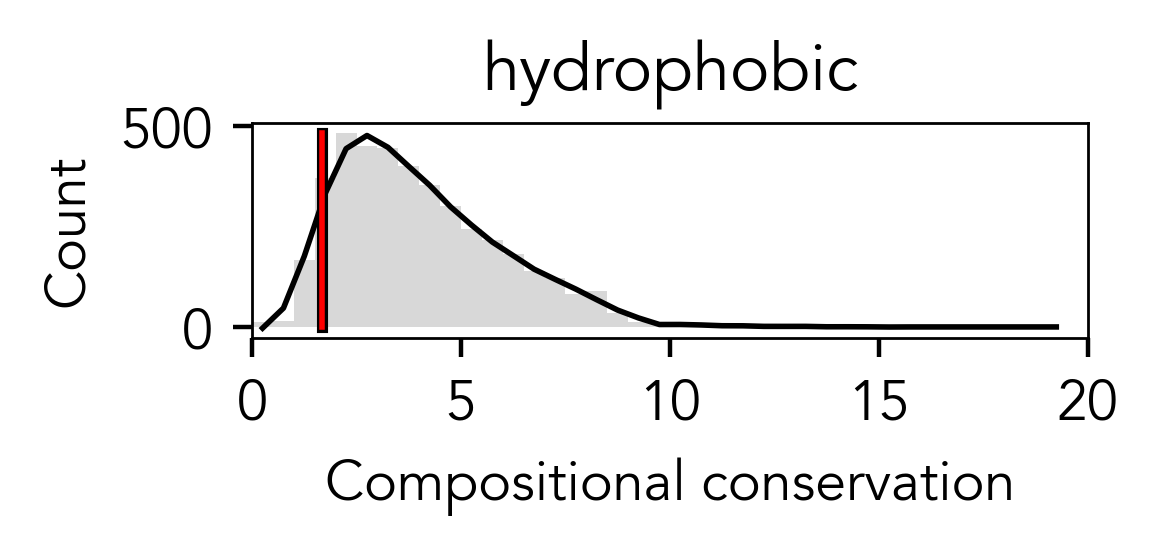

In [13]:
for residue_type in compositional_histogram_data:
    fig, ax = plt.subplots(figsize=(3,1.5), dpi=200)
    bw = 0.5
    tmp = plt.hist(np.array(compositional_histogram_data[residue_type])*100, bins=np.arange(0, 20, bw), color=color_name[residue_type], alpha=0.3)

    plt.plot(np.array(tmp[1][0:-1]+bw*0.5), savgol_filter(tmp[0],7,3), color='k',linewidth=1)

    IDR2_comp_val = IDR2.attribute(f'{averaging_mode}_composition_conservation_{residue_type}')
    plt.plot([IDR2_comp_val*100, 100*IDR2_comp_val], [0,max(tmp[0])],'-k',linewidth=2)
    plt.plot([IDR2_comp_val*100, 100*IDR2_comp_val], [0,max(tmp[0])],'-r',linewidth=1)
    
    print(IDR2_comp_val)

    plt.title(residue_type)
    plt.xlim([0,20])
    plt.ylabel('Count')
    plt.xlabel('Compositional conservation')
    
    plt.tight_layout()
    plt.savefig(f"figures/histo_poor_sequence_conservation_{averaging_mode}_{residue_type}.pdf")

In [14]:
with open('output_data/table_S3_compositional_conservation_in_idrs.csv','w') as fh:

    fh.write('name, start, end, median_alignment_conservation, mean_alignment_conservation, mean_positive, mean_negative, mean_hydrophobic, mean_polar, median_positive, median_negative, median_hydrophobic, median_polar, sequence\n')
    for protein in yeast_proteome:
        for domain in protein.domains:
            if domain.domain_type == 'IDR':
                if 'median_conservation' in domain.attributes:
                    fh.write(f"{protein.name}, {domain.start}, {domain.end}, {round(domain.attribute('median_conservation'),3)}, {round(domain.attribute('mean_conservation'),3)}, {round(domain.attribute('mean_composition_conservation_positive'),3)}, {round(domain.attribute('mean_composition_conservation_negative'),3)}, {round(domain.attribute('mean_composition_conservation_hydrophobic'),3)}, {round(domain.attribute('mean_composition_conservation_polar'),3)}, {round(domain.attribute('median_composition_conservation_positive'),3)}, {round(domain.attribute('median_composition_conservation_negative'),3)}, {round(domain.attribute('median_composition_conservation_hydrophobic'),3)}, {round(domain.attribute('median_composition_conservation_polar'),3)}, {domain.sequence}\n")
                    
                    if domain.attribute('median_conservation') < 0.2:
                        if domain.attribute('mean_composition_conservation_positive') < 0.03:
                            print(domain)
                             
                             

|Domain: IDR (385-412, len=28) in protein YCR084C_Scerevisiae_YCR084C
|Domain: IDR (1-164, len=164) in protein YER150W_Scerevisiae_YDR077W
|Domain: IDR (1-164, len=164) in protein YDR077W_Scerevisiae_YDR077W
